<a href="https://colab.research.google.com/github/acastellanos-ie/NLP-MBD-EN/blob/main/text_classification_practice_dl/practice_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

In [ ]:
# @title Colab Setup

repository_name = "NLP-MBD-EN"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

print("### Cloning the Repository ###")
! git clone $repository_url
print()

print("### Installing requirements ###")
! pip3 install -Uqqr $repository_name/text_classification_practice_dl/requirements.txt

%cd $repository_name/text_classification_practice_dl

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

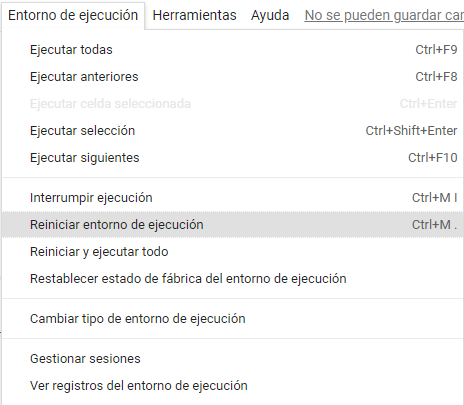

Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

In [ ]:
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB


# Introduction


In this practice we will address a text classification problem: we will try to predict whether a given tweet is about a real disaster or not. In particular I propose you the scenario presented at the [Real or Not? NLP with Disaster Tweets Kaggle Competition.](https://www.kaggle.com/c/nlp-getting-started/leaderboard).

To that, I am going to follow 2 different approaches:
- Apply traditional text classification methodologies based on "simple" Machine Learning models
- Apply state-of-the-art deep learning models

I have decided to give Deep Learning a try by applying the classification models explained in class.
However, the dataset we have at our disposal includes "only" 65K documents. We all know that to apply Deep Learning you need tons of data and weeks of training, right?

Well, this in not true, or at least, this is not anymore completely true thanks to **Transfer Learning**. If you are training a huge model from scratch, you do need a lot of data and GPU time. Lucklily for us, these huge models are already pre-trained for many languages using large datasets (e.g. Wikipedia). All we have to do is to adapt these models to our particular domain. 65K documents are not enough to learn English, but they are definitely enough to learn the nuances of the dataset.

Cool, now we have a model adapted to the specific language in my dataset but the business case was to create a classifier. Why am I even doing all of this? In the traditional ML methodologies we were feeding our algorithms with a rather simple representation of our textual contents (The TF-IDF vectors). Now, thanks to the fine-tune pre-trained models, I can feed my classifier with a much more detailed and accurate representation of the input textual content. Therefore, it should be easier to the classifier to better categorize the textual content.


Summing up, my strategy will be:

1.   Use a pre-trained English Language Model trained over a large dataset as starting point.
2.   Adapt this language model to our domain. To that end, I will retrain the model to learn the particular aspects of the dataset.
3.   Create a Machine Learning Classifier on top of the dataset language model


**Side note: I have trained this model on Google Colab to be able to use a GPU.For this reason, I did not include anything about the configuration of the GPU or the installation of the required libraries. To execute it I do recommend you to update it to Google Colab**


# STEP 1: Loading and preprocessing the data

Before starting to play with the DeepLearning models we need to read, inspect and clean (if needed) the dataset.

The dataset is provided in 2 different CSV files (one for training and another one for test)

In [ ]:
training_df = pd.read_csv('nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df.head()

As you can see, the training set contains the dependent variable (1 or 0, real or not) as well as some independent variables: the actual text of the tweet and some of the metadata related

In [ ]:
test_df = pd.read_csv('nlp_disaster/data/test.csv', sep=',', index_col=0)
test_df.head()

The test set contains the same independent variables, but no label whatsoever. This is the common scenario proposed by Kaggle. You get a training set to create your models and then you have to use these models to predict over the test set.

## Inspecting the data

In this step I will try to make sense of the kind of data that we have.

### Class distribution

The first thing I will do is to inspect the distribution of the target variable to check if we have an imbalace problem

In [ ]:
import seaborn as sns
from collections import Counter

# Build your order
order = [lab for lab, _ in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])]

# Now tell countplot to use 'target' as both x and hue
sns.countplot(
    x="target",
    hue="target",
    data=training_df,
    order=order,
    palette="seismic",
    dodge=False,      # so you don't get side-by-side bars
    legend=False      # hides the pointless legend
);

As seen in the figure, There are a slight difference between the number of tweets at each class but nothing to worry about.

### Metadata

Beyond the textual content, we have 2 pieces of information:

 - keyword: the keyword used as query to retrieve the tweets
 - location: Location of the user posting the tweet

Regarding the **keywords**, some of them can be strongly related to a given category, but they can be also highly ambiguous as you can see in the following figure (I used the code in this kernel to create it: https://www.kaggle.com/grantgasser/eda-naive-bayes-bert-glove-fasttext-nn).


In [ ]:
# Copy the dataframes to be able to come back to the original version
df_train = training_df.copy()
df_test = test_df.copy()

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'], palette='seismic')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Given that the keywords are already included in the textual content (the tweets have been retrieved because they include some of the keywords), I have decided to discard this information as I expect that we can learn the importance of the keywords as individual tokens in the textual content.

A future work that I recommend you to consider is to create a classifier just based on the keywords and compare its performance to the most advanced ones that I am proposing in this solution. If a Classifier simply based on the keywords is good enough, perhaps you can stick to it, thus avoiding the complexities of dealing with textual information.

Let's analyze the **location**.

The first aspect to consider is that it has many null values

In [ ]:
print("% of null columns =", (len(training_df.location) - training_df.location.count())/len(training_df))

This is a common features of any twitter dataset. For privacy reasons, many people prefer to keep their locations to themselves. This could change in the case of a disaster, you may want to share your location to give a better understanding of the disaster. I am not going to focus on this idea and, again, I encourage you to test it and check if you can further improve your models.

Summing up, I will only focus on the textual information (`text` column) of the dataset.

### Textual Data

At this point we have to options:

- Focus just on the actual textual content by applying the NLP methodologies addressed in class for text classification
- Increase the information in the dataset by feature-engineer some new features derived from the textual content (e.g., lenght of the tweets, how many stopwords in the tweets, how many urls...).
    
To further analyze if this idea makes sense, I have used the code in this kernel (https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) to create some of these features and plot them against the target variable

In [ ]:
nltk.download('stopwords')

# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in nltk.corpus.stopwords.words("english")]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1], color='green')
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1], color='red')

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

These figures shows the comparison between the class `disaster` and `not disaster` in the training set (on the left) and the comparison between the training and test datasets (on the right) for the different derived features.

In general terms, they do not provide any interesting insight. The distribution of all of these new features are basically the same in both classes and datasets. Consequently, I do not expect them to be of any help for creating the classification models (or at least I do not expect their impact to be large enough to motivate their use). At a closer inspection, the length of the tweets seems to be slightly different between the classes. In this sense, you can test this aspect by including these new feature in your models and check if you can improve your final model.

Anyhow, I have decided to just use the textual information without any new feature to create my models

**Let us now inspect the actual text of the tweets belonging to each class.**

In the following figure we plot the most common words in each class.

In [ ]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

In [ ]:
plot_most_common_features(training_df.text, training_df.target)

Well, this first inspection has been quite a dissapointment.

By plotting the most repeated words in each class we expected to see the words "most representative" of each class. If they were different enough, this will indicate us that we can use them to easily identify the classes.

However, what we see is the same set of uninformative words for both classes. What we are seeing are mostly **stopwords** which are not related to the class and might affect the final classifier. It seems that we will have to remove them latter.

Another issue that we can detect with this inspection is that we have words like `A` and `a` which are the same but are considered as a different term because of the capitalization. It shows that we will have to **normalize** the words.

In addition, we find different forms of the same verb: `are`, `be`, `is`. If you remember for class we have two methodologies to extract the basic form of a word: **stemming and lemmatization**. Stemming will not resolve this problem. As seen in class it finds the basic forms (stems) by chunking the words. In contrast, by lemmatizing the words we will find the basic form of the words (`be` for the words `are`, `be` and `is`).
In any case, it may be worthy to try both approaches.

### Text Processing and Data Preparation

Let's try to address the aforementioned issues. We will start with a basic Natural Language Pre-processing:

 - Extract English Words
 - Stem words to avoid over counting same meaning words
 - Removing stop words


I will join training and test datasets to apply the same process to both

In [ ]:
dataset = pd.concat([training_df,test_df], sort=True)

To encapsulate this process and facilitate its application, we create a function `process_text` which encloses all the text processing

In [ ]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    words = letters_only.lower().split()

    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in words if not w in stops]

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]

    return( " ".join( stemmed ))

We now apply this function to the textual content.
Just in case we need the raw text later, we will create new columns to store the processed text.

In [ ]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

In [ ]:
plot_most_common_features(dataset.clean_text, dataset.target)

It looks much better now!
We have removed all the stopwords and the terms that we see now are much more representative (e.g., `bomb`, `crash` among the tweets about actual disasters).

However, we also see another meaningless words (e.g., `co`, `http`) in both classes. This kind of terms are known as domain-stopwords. I.e., they are not stopwords of the English language but they are very common terms in our particular domain (e.g., HTML keywords). As I cannot see how they can inform about the category of the tweet, I have decided to remove them.

To that end, I am going to modify the `process_text` to clean all of the possible domain stopwords that I can find in the textual content of the tweets. I have found the following function in this Kaggle kernel: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert


In [ ]:
def clean(tweet):

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)


    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)

    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet)
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)

    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')

    return tweet

In [ ]:
def process_text(raw_text):

    raw_text = clean(raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    words = letters_only.lower().split()

    stops = set(stopwords.words("english"))
    not_stop_words = [w for w in words if not w in stops]

    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]

    return( " ".join( stemmed ))

In [ ]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
plot_most_common_features(dataset.clean_text, dataset.target)

Right, now we only see what appears to be relevant terms among the most common ones.


We now split the dataset again for the creation and evaluation of the models into training and test


In [ ]:
X_train = dataset[0:len(training_df)][["clean_text"]]
y_train = dataset[0:len(training_df)][["target"]]
X_test = dataset[len(training_df):len(dataset)][["clean_text"]]
y_test = dataset[len(training_df):len(dataset)][["target"]]

# STEP 2: Machine Learning Models

Now that we have a clean version of the dataset we can move to the training of ML models.

Before starting the training process, we need to take care of some aspects related to the data format

Labels are in string format. It is preferred to have them numerically encoded. To that end, sklearn provides a `LabelEncoder` to facilitate this encoding

In [ ]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.target.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.target.values)


We then need to convert the textual content into numerical feature vectors (i.e., Vector Space Model), applying the bags of words representation:

 - Assign an id to each word of the training set.
 - For each document `d`, count the number of occurrences of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Sklearn has also some useful functions for this textual processing that we will make use of.

We are going to use the `CountVectorizer` for creating the feature vectors and the `TfidfTransformer` which returns the Document-Term Matrix with the terms weighted by means of their TF-IDF score.

In [ ]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)

Now we have our dataset in the needed format that will allow us to create our baseline models

To train, evaluate and compare the models I've created a function `train_and_evaluate_classifier` that takes the training data, a classifier definition and a grid to optimize the classifier to train a predictive model.

In [ ]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""

    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)

    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()

    return grid_search

## Approach #1: Naïve Bayes

Let's apply Naïve Bayes for the textual classification.
Remember for class that in order to predict the class of a given document we compute the "Maximum Apriori Probability":

\begin{equation*}
MAP   = max({P(c_1|w_1,...w_n), P(c_2|w_1,...,w_n)})
\end{equation*}

To compute $P(c|w_1,...w_n)$, we will use the Bayes theorem:

\begin{equation*}
P(c|w_1,...w_n) = \frac{P(w_1,...,w_n|c)P(c)}{P(w_1,...,w_n)}
\end{equation*}

Being "naive", we can assume that w_1, ..., w_n are independent among them. Therefore:

\begin{equation*}
P(w_1,...,w_n|c) = P(w_1|c)P(w_2|c) ... P(w_n|c)
\end{equation*}

We use the column `clean_text` to create the features through the count vectorizer object

In [ ]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

80% of Accuracy is a strong baseline. In this solution I am going to explore more solutions to further enhance these results. Nevertheless, if you are trying to create a production system, it could be enough. As you could have seen, it is quite easy and fast to train a NB classifier.

Only if you actually need a state of the art classifier you could delve into the following methodologies.

## Approach 2: SVM

As seen in class, SVM is better suited for text classification, providing a more accurate model. By making use of sklearn, we are going to implement a SVM classifier and then apply it to detect fake news and check if we can improve our baseline Naïve Bayes model.


We now make use of the `train_and_evaluate_classifier` function

In [ ]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
 ]

svm_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, SVC(), svm_grid)

As expected, better than our baseline model based on NB.

In general, SVM is a more suited algorithm for text classification than Naive Bayes. It's up to you to decided if the increase in complexity is justified by the increase in performance

## Approach 3: MaxEnt Classifiers

In class we studied the maxent classifiers. They are probabilistic models especially suited for text classification since they do not assume any independence between the textual contents.
They are expected to offer better results than simple NB without the complexity of SVM. Let's try it.

In [ ]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
max_ent_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

Results are close to those offered by NB.

Usually this is not the case: MaxEnt usually works way better for text classification than NB. However, we have to consider again the special scenario in which we are: Twitter.

In Twitter, the textual content is very scarce (we have only a bunch of words). In this scenario, even simple approaches like NB are able to capture the overall meaning of a textual content. If you think about it, in order to understand if some tweet is about an actual disaster, many times is just enough to detect a couple of highly words (fire, California), instead of having to deeply understande the textual content of the tweets. In this sense, the independence assumption in which NB relies is not so wrong anymore, thus offering a similar result than more "intelligent" approaches.

Summing up, with traditional ML we have been able to achieve a performance around 80%. That's not bad, however I would like to give a try to some of the most advanced classification methodologies, based on Deep Learning.

As you will see, thanks to some libraries it is not so difficult/scary as it might seem.

# STEP 3: Recurrent Neural Nets (RNN)

In class we have discussed about this kind of Deep Learning models. RNNs apply a DL architecture focused on modeling sequential information. In particular, Long Sort Term Memory Networks, a subtype of RNNs, are especially well suited for text. Since they are able to capture short term as well as long term relationships, commonly present in textual information.

In more detail we are going to make use of the [AWD-LSTM](https://arxiv.org/abs/1708.02182) model: one of the top-performing approaches in the text classification literature. Do not worry, you do not need to implement by yourself the model in the paper. Luckily for us, their authors have already implemented it in the fast.ai library


## Fast AI

To facilitate the training of this deep learning approach, I will make use of the [fast.ai library](https://www.fast.ai/). In particular, the [`text`](https://docs.fast.ai/text.html) module of the fast.ai library contains all the necessary functions. Specifically:

- [`text.transform`](https://docs.fast.ai/text.transform.html#text.transform) contains all the scripts to preprocess the data, from raw text to token ids,
- [`text.data`](https://docs.fast.ai/text.data.html#text.data) contains the definition of [`TextDataBunch`](https://docs.fast.ai/text.data.html#TextDataBunch), which is the main class we need in NLP,
- [`text.learner`](https://docs.fast.ai/text.learner.html#text.learner) contains helper functions to quickly create a language model or an text classifier.

For more information about the library and how to apply it to text classification, please refer to the related [chapter](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) of the fast.ai book



## Training a classifier model


To create my model I am going to apply the following steps:

1. Fine-tuning an [AWD-LSTM](https://arxiv.org/abs/1708.02182) model to create a language model based on our data.
1. Building a classifier based on the learned language model

### Reading and viewing the data

First let's import everything we need for text.

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *

import torch
from fastcore.foundation import L

# allow torch.load to unpickle L
torch.serialization.add_safe_globals([L])

### Getting your data ready for modeling


In the same way that we needed to use the Vectorizers in sklearn to create the docment-term matrix to fed the machine learning models, we need to properly format the input textual data so we can feed the DeepLearning model.

fast.ai provides some helpful loaders to format the input data to the format required by the Deep Learning Model.

The main structure we need to create is the [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) that creates the training and validation sets by grabbing the textual data from the required columns.

Here we'll use the method <code>from_df</code> of the [`TextLMDataBunch`](https://docs.fast.ai/text.data.html#TextLMDataBunch) (to get the data ready for the fine-tuning of the language model) and [`TextClasDataBunch`](https://docs.fast.ai/text.data.html#TextClasDataBunch) (to get the data ready for the classification step) classes.

In [ ]:
# Language model data
df_all = pd.concat([training_df, test_df])

dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
).dataloaders(df_all, bs=64, seq_len=40)

dls_lm.show_batch(max_n=5)

We are not applying any data cleaning given that we need the original text in the tweet.

Think about it, we are trying to update the pre-trained language model with the data in our dataset. LMs are trained by asking the model to predict the most likely next word/s, given an input sentece (e.g., The dog is ...). If we remove the stopwords or we stem the words, the LM is not going to be able to learn from the actual input sentence (e.g., The dog is ... after stopword removal and lematization will be transformed to [dog, be]).

### Fine-tuning

We can now use the `data_lm` object I created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an [AWD-LSTM architecture](https://arxiv.org/abs/1708.02182) available. To use it, we can create a learner object that will directly create the model, download the pretrained weights and be ready for fine-tuning.

Neural nets in general, and the AWD_LSTM model in particular, are well know for having a huge number of hyperparameters to optimize.

I am deliberately using the default values that fast.ai implements. fast.ai is well know for their superconvergent models that are able to train in just a few steps. This is done through their thoughtful research about initializations, regularization, optimizers and batch normalization. All of these findings are implmented in their default values, so, for most of the tasks, we can safely use them.

There is though an hyperparameter that requires careful optimization, the learning rate. Learning rate refers to the "speed" at which the optimizer is updating the neural net parameters in the backpropagation step. Pick a large learning rate and your NN will never converge. Pick a small rate and you will wait forever to see your NN achive a good performance or to see your NN stuck at a local minima.

I will make use of the `lr_find` method in fast.ai to make sense of the values that are optimal for my data



In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.lr_find(start_lr=1e-6, end_lr=10)

What we see in this figure is the projection of how the model will perform based on different learning rates.

We can see that around 5e-01 the training starts to go south (i.e., the loss/error starts rocketing). The minimal loss is around 1e-1. Nevertheless, we have to choose a value that is approximately in the middle of the sharpest downward slope. Why?! Well, for a more intuitive explanation you can check this [blog post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html). Basically, the reason is:

> [...] the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion.


This is given as an indication by the LR Finder tool, so let's try 1e-2.



In [ ]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7,0.8), div=10)

After just only one epoch we have a pretty good result (i.e., remember that we are still fine-tuning the language model, so guessing right about one third of times which is going to be the next word is a pretty good model). It seems that the default values of the library based on the super-convergence approach are just fine. So, I am not going to pay attention to them anymore. In a more developed solution, we could spend some time trying to optimize them.

At this point it is important to explain what are we actually training. As I explained before, we have a pre-trained model of the English language. By pretrained, we mean nothing more the Neural Net has a set of weights already learned.
This model is quite deep, it has many number of layers with millions of parameters (a.k.a. weights) to learn. It has been posible to train such a huge model, because the entire Wikipedia was used.

However, we only have a small bunch of news reports to adapt/fine-tune the model to our domain. Fine-tuning is nothing more than modifying a little bit the weights of the model, so they reflect the particular relationships in our data. But, since our dataset is rather small, if we try to retrain all the layers in the model, we will completely destroy it (the model will catastrophically forget everything learned from Wikipedia).

If you think about it, it makes sense, the deeper layers in the model are actually learning the basic aspects of the language, while shallow layers are in charge of more high-level relationships. We do not want to change the deeper layers. Basic language relationships are the same in our dataset than in the entire English language (e.g., verb tenses, subject-object relationships). What we actually want to modify is the last layers of the model in charge of learning the high level relationships (e.g. Obama does something). Well, that's exactly what the default training method in fast.ai is doing: It freezes the deeper layers so you do not modify them while you are fine-tuning your model. How convenient, right?

In the previous step, we have fine-tuned the LM to the particular content of our dataset. To do this, we just trained the last layers in our model to avoid forgetting everything. Now that our model is in a *stable* state (it has learned from our data without losing what learned from Wikipedia), we can further train our model by unfreeze all the layers.

The rationale is the following: we can slightly change the weights of all the layers so even the most basic aspects of the language can be redefined according to our data (e.g. Napoleonic wars Wikipedia pages can learn the model that France<-->invade is a likely outcome; however, I do not expect to read anything about a French invasion in the HuffPost).

It has been experimentally proven that this process can improve the performane of Deep Learning models (see this [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf) for more details). We have to be extremely careful with this process, otherwise we will ruin all our work. To that end, I have reduced my learning rate by an order of magnitude



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

Cool! Only 5 epochs and my model has been improved.


To understand what our language model is learning, you can run the [`Learner.predict`](https://docs.fast.ai/basic_train.html#Learner.predict) method and specify the number of words you want it to guess.

In [ ]:
TEXT = "Haha South Tampa"
N_WORDS = 20
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75)
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))


It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model) while it has adapted the conversation to the content of the dataset.



I could futher train or experiment with more hyperparameters, but since the language model is not the final outcome and the LM seems good enough, I will move on to the classification step.


We can save the model for later uses. We need to save the encoder (the part that given a textual content creates the representation) which is the only part of the model needed for classification in the next section (i.e., the other part is the decoder in charge of translating the textual representation back to the text again).

In [ ]:
learn.save_encoder('ft_enc_extended')

### Building a classifier


We now have the language model fine-tuned to our dataset. The next step is create and fine-tune the classification model.

To recap, a language model predicts the next word of a document, so it doesn't need any external labels. The classifier, however, needs an annotated dataset
containing the texts to classify and their labels (`disaster` and `not-disaster` in our case)

In [ ]:
dls_class = DataBlock(
    blocks=(
        TextBlock.from_df('text', # We take the textual information from the column "text" in the dataset
                          seq_len=40, # Maximum tweet length
                          vocab=dls_lm.vocab # We use the same vocabulary representation than the one used for the LM
                          ),
            CategoryBlock), # Because we will use these data for classification
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2)).dataloaders(training_df, bs=64) # Randomly splits the dataset (20% for Validation, 80% for training)

dls_class.show_batch(max_n=10)

It's now time to actually create the classifier taking our fine-tuned encoder. For this step we need the `data_clas` object we created earlier.

For this step, I will use again the default values in fast.ai to create a classification model. In this case, I will use the `text_classifier_learner`. We need to also tell the classifier that we want to use the fine-tuned encoder that we have just learned.

In [ ]:
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.8, metrics=[accuracy,FBeta(beta=1)]).to_fp16()
learn.load_encoder('ft_enc_extended')
learn.freeze()

In [ ]:
learn.lr_find()

Thanks to fast.ai super-convergence strategies, I think that just one epoch should be enough. Let's see

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('lstm_1')

Great! As I expected the accuracy has improved: 82%.

This is in the line of the accuracy reported by the simpler models that I already implemented in the other markdown. However, we need to compare them in terms of the F1 macro AVG as we discussed. In additon we can futher train this model. As in the language modeling training, we have just trained the last layers of the model, we can gradually unfreeze the rest of the model and train it together.

In this case I will not unfreeze all the model at a time, but in different steps. This gradual unfreezing has been experimentally proven to improve the training process (again, check Howard and Ruder's paper).

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.save('lstm_2')

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/2/(2.6**4),1e-2/2))

In [ ]:
learn.save('lstm_3')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-2/10/(2.6**4),1e-2/10))

In [ ]:
learn.save('lstm_4')


As can be seen in the results, our model is now offering accuracies up to 85%! Better than those we had with LR, RF or SVM.

In order to have a full report of this model performance, I will ask the model to offer me all the predictions and inspect the confusion matrix and the classification report

In [ ]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

As can be seen in both the confusion matrix and in the classification report, the model is better not only in terms of accuracy, but also in its performance for all the classes when compared to the non Deep Learning models. Something that I care about since the start.

As expected, there are some classes for which the model performs better (they are easier to predict or we have more data for them). However, we get a reasonable performance for most of the classes (I am a little bit worried by class 8, but since we do not have many data I guess I can accept this result)

Finally, saving the model object to reuse it.

In [ ]:
learn.save('final_lstm_model')

# STEP 4: Transformers. Is attention all you need for Text Classification?

In this third solution I want to go a step beyond to apply the most advanced methodologies in the NLP state-of-the-art: Transformers. We have already discussed Transformers in class, as well as their advantages over other methodologies.

There is still some controversy about what technique is better suited for Text Classification (and NLP in general): RNNs or Transformers. Different research works suggest different experimental results. Nevertheless, it seems that Transformer-based models are starting to outperform RNN-based systems. Let's check what happens in our problem.

Using Transformes might sound scary (many hyperparameters, you have to deal with tensor, shapes, transform your data....). However, there are a number of libraries and wrappers that will make your life easier (or at least less miserable). In particular, in this solution I will make use of two of them, which I strongly recommend you to use if you want to experiment with these ideas:

 - [HuggingFace](https://huggingface.co/): They provide under the [`transformers`](https://github.com/huggingface/transformers) library a large number of pre-trained state-of-the-art pretrained NLP models together with some handy functions to load them, fine-tune them and put them into practice.
 - [ktrain](https://github.com/amaiya/ktrain): Python library that provides a higher-level wrapper that facilitates the use of Deep Learning based NLP models (HuggingFace models among them).

Let the fun begin!

**Disclaimer:This solution is based on this [post](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed) as well as in the [ktrain](https://github.com/amaiya/ktrain) library documentation**



In [ ]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

import tensorflow as tf
import ktrain
from ktrain import text

tf.random.set_seed(42)

## Create the Transformer Model

In this step I will take the dataset, preprocess it (via ktrain) and create a Text Classifier based on a Transformer model. This process follows a similar intuition to what we already did with fast.ai in the other markdown, although it is not exactly the same.

We will start again with a Language Model pre-trained using a huge dataset: a model that speaks English. The model in particular is the well-know BERT. We already explained the basic rationale of BERT in class, but just as a reminder: it applies the idea of Self-Attention (instead of an RNN architecture) to learn the sequential information of textual contents. If you want to know more, let me refer you again to this great blog post: http://jalammar.github.io/illustrated-bert/.

As we also did in the other markdown, we have to now fine-tune this model: Retrain the model to our specific dataset and task. In more detail, the BERT model provides a encoder block with pre-trained weights which gives BERT a general understanding of English. The BERT encoder block will look at each input tweet as a whole, producing an output that contains an understanding of the textual content of the tweet. This representation is then feed to a Text classifier. Thanks to ktrain, this process only involves a handful of lines of code.

In [ ]:
trn, val, preproc = text.texts_from_df(training_df,'text',preprocess_mode='bert',label_columns='target',verbose=True, maxlen=32) # Process the input tweets based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

## Train the Model

It is now time to actually train (fine-tuning + train the text classifier) the model. This process might take a while. BERT is huge and memory-hungry. Consequently, it is pretty slow for both training and prediction.

Since our dataset is not very large, you can train the model in a reasonable amount of time if you have a GPU at your disposal (if you don't just use Google Colab or another platform offering GPUs as I did. Do not try to train this model in your laptop if you do not want to potentially wait for hours).

Nevertheless, because of this complexity, BERT is not very suitable for production environments. In this sense, I recommend you to take a look to DistilBERT. DistillBERT is a “distilled” (a.k.a. reduced) version of BERT that is smaller and faster while retaining most of BERT’s accuracy. Check this blog post from HuggingFace for more details on DistillBERT and the whole idea of Knowledge Distillation: https://medium.com/huggingface/distilbert-8cf3380435b5).

There are many other pre-trained models that HuggingFace provides. You can check the entire Model zoo in the following link: https://huggingface.co/transformers/pretrained_models.html.

The first thing to do is to find the optimal learning rate (as we did with our LSTM model). As you can see the ktrain interface is quite similar to the fast.ai interface.


In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

As we already now, we want a learning rate which is more or less in the middle of the steeper slope of the loss function. In our case is somewhere about 1e-4.

I will train the model for a some of epochs and see what happens.

In [ ]:
learner.autofit(lr=1e-4, # Learning Rate
                epochs=5, # Number of epochs to train the model
                early_stopping=2, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='nlp_disaster/models/transformer_cpt_1' # After each epoch we store a checkpoint of the model
                );

The first thing to notice is that the model takes a lot of time to train! Way more than the LSTM model. This is one of the donwsides of using a Transformer model. I only recommend you to use them if they do provide a significant improvement compared to the LSTM model. Sadly, this is not the case, under this configuration we are not able to improve the 0.85 accuracy obtained by the previous LSTM model.

I do encourage you to try different paramaters (e.g., learning rate, model) to see if you can improve this performance


In [ ]:
learner.save_model('nlp_disaster/models/transformer_1') # Saving the trained model

We are going to now unfreeze the whole model to allow its retraining. As with the LSTM model, be careful! If you are too much aggressive with this re-training you will end up ruining the model.

In this sense, I have reduced the learning rate by a magnitude order and try to retrain for one more epoch an check the performance

In [ ]:
learner.unfreeze()
learner.fit_onecycle(1e-4/10, 1, checkpoint_folder='nlp_disaster/models/transformer_cpt_2')

No apparent improvement. It seems that, at least for this case, LSTM models are preferred.

In [ ]:
learner.save_model('nlp_disaster/models/transformer_2') # Store the final model


# STEP 5: Evaluate and Inspect the Model

Large Deep Learning models are well-know for being quite black-boxy. However, in this section, I would like to provide you with some tools to evaluate and analyze them.

First I will create the confussion matrix to understand the performance of the model and to check the accuracy and F-measure.


In [ ]:
learner.validate(class_names=['Regular Tweet','Disaster Tweet'])

The model is a little bit better on detecting regular tweets; I guess that this is because we have more of those. Anyhow, it works pretty well for both classes in terms of accuracy and F-measure.


If you want to better understand how the model is working ktrain provides some useful techniques.

You can examine the validation tweets about which the model was the most wrong about (i.e., the top losses).

In [ ]:
learner.view_top_losses(n=10, preproc=preproc)

ktrain, actually provides an `explain` method to know that. It allows you to inspect a given tweet and visualize which words contributed the most on deciding the final prediction. We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


And call the `explain` function

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

predictor.explain("[CLS] the government is concerned about the population explosion and the population is concerned about the government explosion . - joe moore [SEP]")

Thanks to this library and the `explain` method you can understand why the model is failing.

For example, the tweet

  `[CLS] the government is concerned about the population explosion and the population is concerned about the government explosion . - joe moore [SEP]`

has been categorized as disaster when it is not about a disaster.

We can understand that the problem is that the model is focusing on the word explosion, which is categorized as highly related to the disaster class. While it seems to be usually right, explosions are a strong indicators of disasters, in this situation the model is not able to understand the the word explosion is being used ironically.

# Step 6: Introduction to Zero-Shot Classification

In this exercise, we delve into the realm of zero-shot text classification using a pre-trained language model. Zero-shot classification refers to the model's ability to accurately categorize text into specific classes without having been explicitly trained on those classes.

## Exercise Overview:

- **Objective**: To classify texts from our dataset as either related to an actual disaster or not, using a zero-shot approach.
- **Model Utilized**: We are employing a model from the Hugging Face library, pre-trained on diverse datasets, enabling it to understand and infer the context and categorize texts appropriately.
- **Method**: The model receives texts and candidate labels ("Disaster" and "Not a Disaster") and predicts the relevance of each label to the text.
- **Evaluation**: We'll assess the model's performance against our dataset's actual labels, using metrics such as accuracy and F1 score to gauge its effectiveness.

This exercise offers a practical application of zero-shot classification, showcasing how advanced NLP models can be leveraged for complex categorization tasks without the need for extensive task-specific training.




The following cell illustrates the application of zero-shot classification using the `transformers` library, specifically leveraging the `facebook/bart-large-mnli` model. This model is an instance of BART (Bidirectional and Auto-Regressive Transformers) adapted for the MultiNLI (Multi-Genre Natural Language Inference) task. It excels in tasks requiring nuanced understanding of context and inference, making it ideal for zero-shot classification where the model must categorize texts into classes not seen during training.

### Applying the Model:
- **Pipeline Initialization**: We initialize the zero-shot classification pipeline with the BART model fine-tuned on the MNLI dataset. The pipeline is a high-level abstraction that wraps around the model and tokenizer, simplifying the task of text classification. It automatically handles the preprocessing of text and post-processing of model predictions
- **Classification Task**: Our task is to classify texts as "Disaster" or "Not a Disaster". To that end, we just need to define what `labels` we want the model to use. This showcases the model's ability to apply learned inferences to new, unseen categories.

Explore the model further on the [Hugging Face Model Hub](https://huggingface.co/facebook/bart-large-mnli).

In [ ]:
from transformers import pipeline

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Example text (replace this with the text from your dataset)
text = "Two cranes restoring a bridge in the central Dutch city of Alphen aan den Rijn collapsed on houses."

# Candidate labels for classifying whether the text is about an actual disaster
labels = ["Disaster", "Not a Disaster"]

# Perform classification
result = classifier(text, labels)

print(f"Text: {text}")
print(f"Labels: {result['labels']}")
print(f"Scores: {result['scores']}")


Now we will apply the previous pipeline to classify the data in our test dataset. As this is a rather slow process, I will subsample 1% of the data and apply it only to that. Feel free to extend it to the entire dataset.

To simplify the application of the zero-shot-classification pipeline, I have created a wrapper function `classify_text`.

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm.auto import tqdm

# Assuming training_df is your DataFrame and it has a column named 'text'

# Load the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Function to classify a single piece of text
def classify_text(text):
    labels = ["Disaster", "Not a Disaster"]
    result = classifier(text, labels)
    return result['labels'][0]

# Wrap your pandas apply with tqdm for a progress bar
tqdm.pandas(desc="Classifying")

sample_df = test_df.sample(frac=0.01)

# Apply the classifier to each row in the DataFrame
sample_df['predicted_label'] = sample_df['text'].progress_apply(classify_text)

# Display the first few rows of the DataFrame to verify
sample_df.head()


Finally, we would like to evaluate the peformance of our model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Map your actual labels to the same format as your predicted labels, if necessary
# For example, if your actual labels are 0 and 1, map them to ['Not a Disaster', 'Disaster']
label_mapping = {0: 'Not a Disaster', 1: 'Disaster'}
sample_df['actual_label'] = sample_df['target'].map(label_mapping)

# Calculate Accuracy
accuracy = accuracy_score(sample_df['actual_label'], sample_df['predicted_label'])
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, and F1 Score
precision, recall, f1, _ = precision_recall_fscore_support(sample_df['actual_label'], sample_df['predicted_label'], average='binary', pos_label='Disaster')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


As you can see, results are far from those achieved by previous methods. The main reasons are:


*   The model that we are using is far from being the state of the art. In that sense, I recommend you to try more advanced models (e.g., LLaMA-2 or ChatGPT)
*   We have not tried any prompt engineering technique. By refining the prompt, we will be able to explain the model exactly what we expect from it
*   We can extend to few-shot learning, meaning we can provide the model with some annotated examples (e.g, tweets classified as Disaster or Not Disaster) to learn from











As an example, in this cell we will make use of an advanced LLM out of OpenAI's interface. The process is similar, but connecting to the OpenAI API via LangChain.

Be aware, that in order to execute it, you need an OpenAI API KEY and pay for it ;)




In [ ]:
# 1) install and import
!pip install --quiet openai langchain

import os
from langchain import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain

# 2) Configure your OpenAI key
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

# 3) Define your labels and example
labels = ["Disaster", "Not Disaster"]
example_text = "A sudden earthquake struck the city at dawn, collapsing buildings."

# 4) Build the prompt
template = """
Classify the following text into one of these labels: {labels}

Text:
{text}

Answer with exactly one label."""
prompt = PromptTemplate(input_variables=["text","labels"], template=template)

# 5) Create and run the chain
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
chain = LLMChain(llm=llm, prompt=prompt)
result = chain.run(text=example_text, labels=", ".join(labels))

# 6) Display the result
print("Input:     ", example_text)
print("Prediction:", result.strip())